In [15]:
import geopandas as gpd
from shapely.geometry import Polygon, LineString, MultiLineString
from shapely.ops import polygonize, unary_union, linemerge
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt

In [9]:
def generate_skeleton(gdf):
    skeleton_lines = []
    for poly in gdf['geometry']:
        # 确保多边形有效
        if not poly.is_valid:
            poly = poly.buffer(0)
        
        coords = [p for p in poly.exterior.coords[:-1]]  # 移除重复的最后一个点
        vor = Voronoi(coords)

        # 生成和处理 Voronoi 图的线
        lines = []
        for idx, ridge in enumerate(vor.ridge_vertices):
            if all(i >= 0 for i in ridge):  # 确保索引有效
                line_points = [vor.vertices[i] for i in ridge]
                line = LineString(line_points)
                if poly.contains(line):  # 确保线在多边形内部
                    lines.append(line)

        # 使用 unary_union 合并和简化线集合
        if lines:
            unioned = unary_union(lines)
            if isinstance(unioned, LineString):
                skeleton_lines.append(unioned)
            elif isinstance(unioned, MultiLineString):
                for line in unioned.geoms:  # 正确处理 MultiLineString
                    skeleton_lines.append(line)
            else:
                skeleton_lines.append(unioned)  # 其他类型的几何形状

    # 将线列表转换为 GeoDataFrame
    return gpd.GeoDataFrame(geometry=skeleton_lines)

In [13]:
def generate_skeleton(gdf):
    """根据GeoDataFrame中的多边形生成中轴线."""
    skeleton_lines = []
    for poly in gdf['geometry']:
        # 确保多边形有效
        if not poly.is_valid:
            poly = poly.buffer(0)
        
        # 从多边形边界提取坐标，移除重复的最后一个点
        coords = [p for p in poly.exterior.coords[:-1]]
        vor = Voronoi(coords)

        # 生成并处理 Voronoi 图的线
        lines = []
        for idx, ridge in enumerate(vor.ridge_vertices):
            if all(i >= 0 for i in ridge):  # 确保索引有效
                line_points = [vor.vertices[i] for i in ridge]
                line = LineString(line_points)
                if poly.contains(line):  # 确保线在多边形内部
                    lines.append(line)

        # 使用 unary_union 合并线，并尝试合并为单一线
        if lines:
            unioned = unary_union(lines)
            if isinstance(unioned, MultiLineString):
                merged = linemerge(unioned)
                if isinstance(merged, LineString):
                    skeleton_lines.append(merged)
                else:
                    try:
                        for line in merged.geoms:
                            skeleton_lines.append(line)
                    except TypeError:
                        skeleton_lines.append(merged)
            else:
                skeleton_lines.append(unioned)

    # 将线列表转换为 GeoDataFrame
    return gpd.GeoDataFrame(geometry=skeleton_lines)


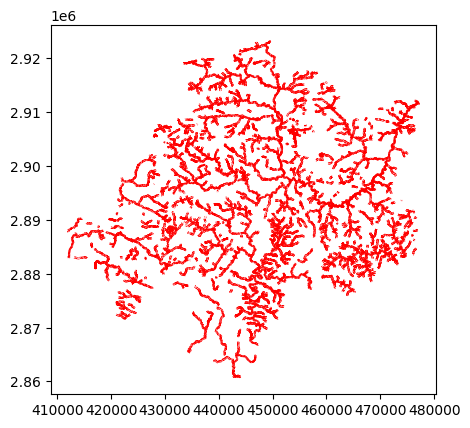

In [14]:
# 使用
input_feature_class = r"C:\Users\Runker\Desktop\testaaa\river.shp"
output_feature_class = r"C:\Users\Runker\Desktop\testaaa\river_line.shp"
# 读取多边形数据
gdf = gpd.read_file(input_feature_class)

# 生成中心线
skeleton_gdf = generate_skeleton(gdf)

# 保存结果
skeleton_gdf.to_file(output_feature_class)

# 可选：绘制结果
fig, ax = plt.subplots()
gdf.plot(ax=ax, color='blue', alpha=0.5)
skeleton_gdf.plot(ax=ax, color='red')
plt.show()
